In [1]:
#Do sanity checks
#Retrain agents with different seeds

import rlcard
from rlcard import models
from rlcard.agents import NFSPAgent, RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)
import numpy as np

In [2]:
import torch

In [3]:
# !python run_rl_multiagent.py

In [5]:
from rlcard.models.limitholdem_rule_models import LimitholdemRuleAgentV1

eval_env = rlcard.make(
    'limit-holdem-collaborative',
    config={
        'game_num_players': 3,
    }
)

agent1 = torch.load(r'./checkpoint_collab/collab_brain2_more_info.pth') #extra info
agent2 = torch.load(r'./checkpoint_collab/collab_brain2_more_info.pth') #extra info
agent3 = torch.load(r'./checkpoint_comp_65k/comp_brain1_65k.pth') #bits set to 0
# agent3 = torch.load(r'./checkpoint_collab/comp_brain1.pth')
# agent2 = torch.load(r'./checkpoint_collab/comp_brain1.pth')
# agent2 = torch.load(r'.\checkpoint_collab\collab_nfsp_friend2.pth')
# agent3 = torch.load(r'.\checkpoint_collab\collab_nfsp_comp3.pth')

In [6]:
eval_env.set_agents([
  agent1,
  agent2,
  agent3
  # LimitholdemRuleAgentV1()
])

In [7]:
win_ratio = []

for _ in range(100):
  
    a = [0 for _ in range(eval_env.num_players)]
    win_num = [0 for _ in range(eval_env.num_players)]
    for i in range(1000):
        eval_env.reset()
        trajectories, payoffs = eval_env.run(is_training=False)
        for idx in range(eval_env.num_players):
        # print(f"Player {idx}: {env.game.get_sta   te(idx)['my_chips']}")
            a[idx] += payoffs[idx]
        win_num[np.argmax(payoffs)] += 1
    win_ratio.append(0.5*(win_num[0] + win_num[1])/win_num[2])



In [8]:
print(a)
print(win_num)

[-117.0, 478.0, -361.0]
[341, 354, 305]


In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
np.mean(win_ratio)

1.0975459773117469

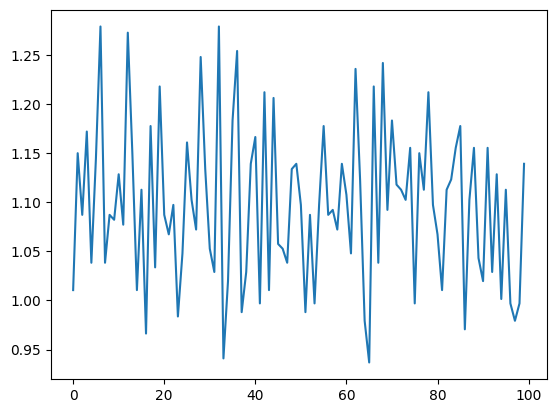

In [11]:
plt.plot(win_ratio)

In [20]:
trajectories, payoffs = eval_env.run(is_training=False)
trajectories = reorganize(trajectories, payoffs)

In [28]:
eval_env.get_perfect_information()

{'chips': [28, 28, 28],
 'public_card': ['D8', 'CK', 'D5', 'S9', 'H3'],
 'hand_cards': [['SQ', 'S4'], ['H7', 'C5'], ['S2', 'SJ']],
 'current_player': 1,
 'legal_actions': ['raise', 'fold', 'check']}

/tmp/ipykernel_535724/893280101.py:23: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


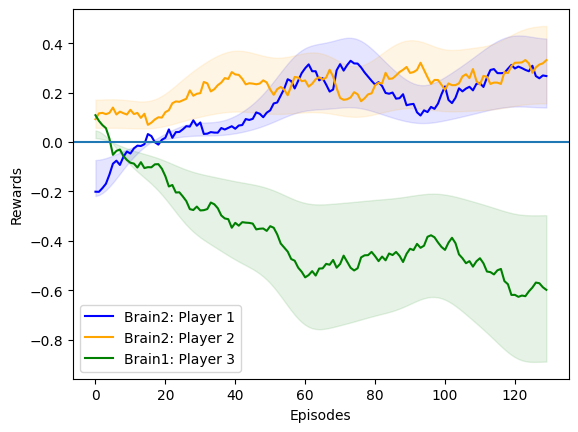

In [3]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
df = pd.read_csv(r'./checkpoint_collab/performance.csv')
# df2 = pd.read_csv(r'.\checkpoint_collab\performancev1.csv')
df['reward'] = df['reward'].apply(ast.literal_eval)
df['player1'] = numpy_ewma_vectorized_v2(np.array(df['reward'].tolist())[:, 0], 50)
df['player2'] = numpy_ewma_vectorized_v2(np.array(df['reward'].tolist())[:, 1], 50)
df['player3'] = numpy_ewma_vectorized_v2(np.array(df['reward'].tolist())[:, 2], 50)

# df2['reward'] = df2['reward'].apply(ast.literal_eval)
# plt.figure(figsize=(20,5))
fig = plt.figure()
ax = plt.gca()

plt.plot(df['player1'], color="blue", label="Brain2: Player 1")
arr = df['player1'].to_numpy()
upper_err = gaussian_filter1d(arr + (arr/2), sigma=5)
lower_err = gaussian_filter1d(arr - (arr/2), sigma=5)

y_pos = np.arange(arr.shape[0])
ax.fill_between(y_pos, upper_err, lower_err, color='blue', alpha=0.1)

plt.plot(df['player2'], color="orange", label="Brain2: Player 2")
arr = df['player2'].to_numpy()
upper_err = gaussian_filter1d(arr + (arr/2), sigma=5)
lower_err = gaussian_filter1d(arr - (arr/2), sigma=5)

y_pos = np.arange(arr.shape[0])
ax.fill_between(y_pos, upper_err, lower_err, color='orange', alpha=0.1)

plt.plot(df['player3'], color="green", label="Brain1: Player 3")
arr = df['player3'].to_numpy()
upper_err = gaussian_filter1d(arr + (arr/2), sigma=5)
lower_err = gaussian_filter1d(arr - (arr/2), sigma=5)

y_pos = np.arange(arr.shape[0])
ax.fill_between(y_pos, upper_err, lower_err, color='green', alpha=0.1)

plt.axhline(0)
plt.ylabel("Rewards")
plt.xlabel("Episodes")
# sns.lineplot(df, x='episode',y='player1')
# sns.lineplot(df, x='episode',y='player2')
# sns.lineplot(df, x='episode',y='player3')
plt.legend()

In [8]:
df.to_csv('ema_performance.csv')